# 离线强化学习

教程链接：[离线强化学习](https://hrl.boyuai.com/chapter/3/%E7%A6%BB%E7%BA%BF%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0)

无论是**在线策略**（on-policy）算法还是**离线策略**（off-policy）算法，都有一个共同点：智能体在训练过程中可以不断和环境交互，得到新的反馈数据。二者的区别主要在于在线策略算法会直接使用这些反馈数据，而离线策略算法会先将数据存入经验回放池中，需要时再采样。
**离线强化学习**（offline reinforcement learning）的目标是，在智能体不和环境交互的情况下，仅从已经收集好的确定的数据集中，通过强化学习算法得到比较好的策略。

![](https://hrl.boyuai.com/static/960.eab822fa.png)

**外推误差**（extrapolation error）是指由于当前策略可能访问到的状态动作对与从数据集中采样得到的状态动作对的分布不匹配而产生的误差，是离线策略算法不能直接迁移到离线环境中的原因。为了减少外推误差，当前的策略需要做到只访问与数据集中相似的数据。满足这一要求的策略称为**批量限制策略**（batch-constrained policy）。

离线强化学习的另一大难点是算法通常对超参数极为敏感，非常难调参。并且在实际复杂场景中通常不能像在模拟器中那样，每训练几轮就在环境中评估策略好坏，如何确定何时停止算法也是离线强化学习在实际应用中面临的一大挑战。此外，离线强化学习在现实场景中的落地还需要关注离散策略评估和选择、数据收集策略的保守性和数据缺失性等现实问题。

In [1]:
import numpy as np
import gym
from tqdm import tqdm
import random
import rl_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
from typing import Tuple

## 1. 保守 Q-learning 算法

实验证明，外推误差主要会导致在远离数据集的点上函数的过高估计，甚至常常出现值向上发散的情况。因此，如果能用某种方法将算法中偏离数据集的点上的函数保持在很低的值，或许能消除部分外推误差的影响，这就是保守 Q-learning（conservative Q-learning，CQL）算法的基本思想。CQL 在普通的贝尔曼方程上引入一些额外的限制项，达到了这一目标。

为了生成数据集，在倒立摆环境中从零开始训练一个在线 SAC 智能体，直到算法达到收敛效果，把训练过程中智能体采集的所有轨迹保存下来作为数据集。这样，数据集中既包含训练初期较差策略的采样，又包含训练后期较好策略的采样，是一个混合数据集。

In [2]:
class PolicyNetContinuous(nn.Module):
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, action_bound:float
        ):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob


class QValueNetContinuous(nn.Module):
    def __init__(self, state_dim:int, hidden_dim:int, action_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x:torch.Tensor, a:torch.Tensor) -> torch.Tensor:
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [3]:
class SACContinuous(rl_utils.BasePolicy):
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, action_bound:float,
            actor_lr:float, critic_lr:float, alpha_lr:float, 
            target_entropy:float, tau:float, gamma:float, device:torch.device
        ):
        # 5个网络：1个策略网络，2个价值网络，2个目标价值网络
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound
                        ).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim
                        ).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim
                        ).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim
                        ).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim
                        ).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                            lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                            lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                            lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], 
                                            lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state:torch.Tensor) -> list[int]:
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]

    def calc_target(self, 
            rewards:torch.Tensor, next_states:torch.Tensor, dones:torch.Tensor
        ) -> torch.Tensor:
        """计算目标Q值"""
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net:nn.Module, target_net:nn.Module):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(
                param_target.data * (1.0 - self.tau) + param.data * self.tau
            )

    def update(self, transition_dict:dict):
        states = torch.tensor(transition_dict['states'],
                            dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                            dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                            dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                            dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                            dtype=torch.float).view(-1, 1).to(self.device)
        # 和之前章节一样,对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(
                            F.mse_loss(self.critic_1(states, actions), td_target.detach())
                        )
        critic_2_loss = torch.mean(
                            F.mse_loss(self.critic_2(states, actions), td_target.detach())
                        )
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(
                        -self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value)
                    )
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
                        (entropy - self.target_entropy).detach() * self.log_alpha.exp()
                    )
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [7]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(
            state_dim, hidden_dim, action_dim, action_bound,
            actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device
        )

return_list = rl_utils.train_off_policy_agent(
                env, agent, num_episodes, replay_buffer, minimal_size, batch_size
            )

Iteration 9: 100%|██████████| 10/10 [01:24<00:00,  8.47s/it, episode=100, return=-243.754]


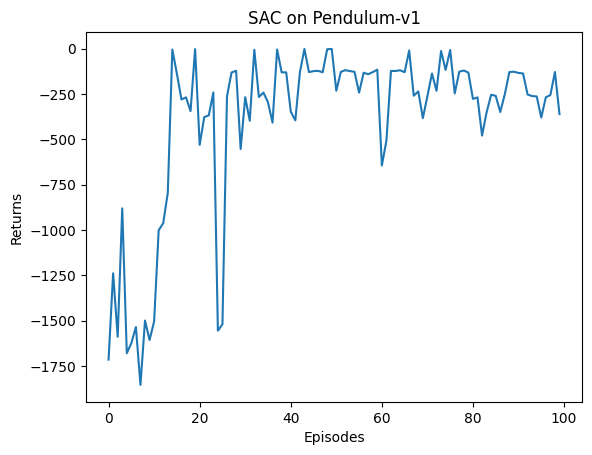

In [8]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

接下来实现CQL算法，它在 SAC 的代码基础上做了修改。

In [11]:
class CQL:
    ''' CQL算法 '''
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, action_bound:float,
            actor_lr:float, critic_lr:float, alpha_lr:float, target_entropy:float, 
            tau:float, gamma:float, device:torch.device, beta:float, num_random:int
        ):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                        lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                        lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                        lr=critic_lr)
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  #对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                        lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau

        self.beta = beta  # CQL损失函数中的系数
        self.num_random = num_random  # CQL中的动作采样数

    def take_action(self, state:torch.Tensor) -> list[int]:
        state = torch.tensor(np.array([state]), dtype=torch.float).to(device)
        action = self.actor(state)[0]
        return [action.item()]

    def soft_update(self, net:nn.Module, target_net:nn.Module):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(
                param_target.data * (1.0 - self.tau) + param.data * self.tau
            )

    def update(self, transition_dict:dict):
        states = torch.tensor(transition_dict['states'],
                                dtype=torch.float).to(device)
        actions = torch.tensor(transition_dict['actions'],
                                dtype=torch.float).view(-1, 1).to(device)
        rewards = torch.tensor(transition_dict['rewards'],
                                dtype=torch.float).view(-1, 1).to(device)
        next_states = torch.tensor(transition_dict['next_states'],
                                dtype=torch.float).to(device)
        dones = torch.tensor(transition_dict['dones'],
                                dtype=torch.float).view(-1, 1).to(device)
        rewards = (rewards + 8.0) / 8.0  # 对倒立摆环境的奖励进行重塑

        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        critic_1_loss = torch.mean(
                            F.mse_loss(self.critic_1(states, actions), td_target.detach())
                        )
        critic_2_loss = torch.mean(
                            F.mse_loss(self.critic_2(states, actions), td_target.detach())
                        )

        # 以上与SAC相同,以下Q网络更新是CQL的额外部分
        batch_size = states.shape[0]
        random_unif_actions = torch.rand(
                                [batch_size * self.num_random, actions.shape[-1]],
                                dtype=torch.float
                            ).uniform_(-1, 1).to(device)
        random_unif_log_pi = np.log(0.5**next_actions.shape[-1])
        tmp_states = states.unsqueeze(1).repeat(
                                            1, self.num_random, 1
                                        ).view(-1, states.shape[-1])
        tmp_next_states = next_states.unsqueeze(1).repeat(
                                            1, self.num_random, 1
                                        ).view(-1, next_states.shape[-1])
        random_curr_actions, random_curr_log_pi = self.actor(tmp_states)
        random_next_actions, random_next_log_pi = self.actor(tmp_next_states)
        q1_unif = self.critic_1(tmp_states, random_unif_actions
                            ).view(-1, self.num_random, 1)
        q2_unif = self.critic_2(tmp_states, random_unif_actions
                            ).view(-1, self.num_random, 1)
        q1_curr = self.critic_1(tmp_states, random_curr_actions
                            ).view(-1, self.num_random, 1)
        q2_curr = self.critic_2(tmp_states, random_curr_actions
                            ).view(-1, self.num_random, 1)
        q1_next = self.critic_1(tmp_states, random_next_actions
                            ).view(-1, self.num_random, 1)
        q2_next = self.critic_2(tmp_states, random_next_actions
                            ).view(-1, self.num_random, 1)
        q1_cat = torch.cat([
                    q1_unif - random_unif_log_pi,
                    q1_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
                    q1_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
                ], dim=1
            )
        q2_cat = torch.cat([
                    q2_unif - random_unif_log_pi,
                    q2_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
                    q2_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
                ], dim=1
            )

        qf1_loss_1 = torch.logsumexp(q1_cat, dim=1).mean()
        qf2_loss_1 = torch.logsumexp(q2_cat, dim=1).mean()
        qf1_loss_2 = self.critic_1(states, actions).mean()
        qf2_loss_2 = self.critic_2(states, actions).mean()
        qf1_loss = critic_1_loss + self.beta * (qf1_loss_1 - qf1_loss_2)
        qf2_loss = critic_2_loss + self.beta * (qf2_loss_1 - qf2_loss_2)

        self.critic_1_optimizer.zero_grad()
        qf1_loss.backward(retain_graph=True)
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        qf2_loss.backward(retain_graph=True)
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(
                        -self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value)
                    )
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
                        (entropy - self.target_entropy).detach() * self.log_alpha.exp()
                    )
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [12]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

beta = 5.0
num_random = 5
num_epochs = 100
num_trains_per_epoch = 500

agent = CQL(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
            critic_lr, alpha_lr, target_entropy, tau, gamma, device, beta,
            num_random)

return_list = []
for i in range(10):
    with tqdm(total=int(num_epochs / 10), desc='Iteration %d' % i) as pbar:
        for i_epoch in range(int(num_epochs / 10)):
            # 此处与环境交互只是为了评估策略,最后作图用,不会用于训练
            epoch_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                state = next_state
                epoch_return += reward
            return_list.append(epoch_return)

            for _ in range(num_trains_per_epoch):
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {
                    'states': b_s,
                    'actions': b_a,
                    'next_states': b_ns,
                    'rewards': b_r,
                    'dones': b_d
                }
                agent.update(transition_dict)

            if (i_epoch + 1) % 10 == 0:
                pbar.set_postfix({
                    'epoch':
                    '%d' % (num_epochs / 10 * i + i_epoch + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 10/10 [04:44<00:00, 28.41s/it, epoch=100, return=-218.520]


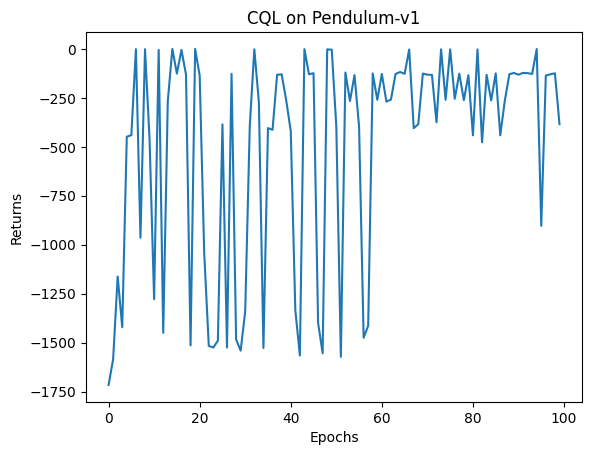

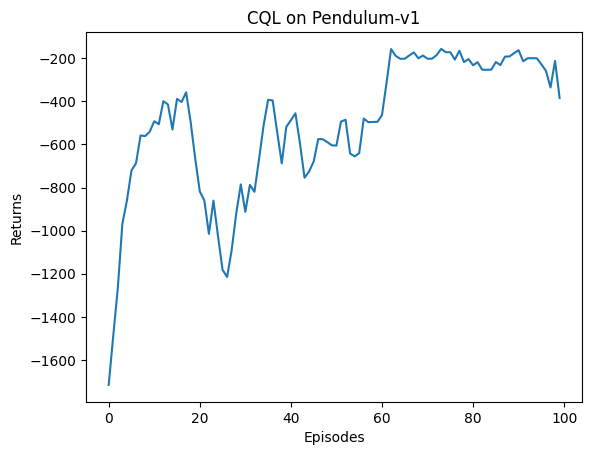

In [13]:
epochs_list = list(range(len(return_list)))
plt.plot(epochs_list, return_list)
plt.xlabel('Epochs')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()